In [1]:
import sys
import os
import yaml
import numpy as np
import pandas
import pathlib
import time
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
import cmocean as cm

import xarray
from matplotlib.offsetbox import AnchoredText
sys.path.insert(1, '../scripts/')
from ssm_utils import reshape_fvcom

In [2]:
with open('../etc/SSM_config_SOG.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
    # get shapefile path    
    shp = ssm['paths']['shapefile']


mpl.rc('font', size=11)
# some of the following may be repetetive but can also be set relative to the font value above 
#    (eg "xx-small, x-small,small, medium, large, x-large, xx-large, larger, or smaller"; see link above for details)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', titlesize=16)
mpl.rc('axes', labelsize=12)
mpl.rc('figure', titlesize=16)
mpl.rc('text', usetex=False)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

# Define dimension sizes and load shapefile
gdf = gpd.read_file(shp)
gdf = gdf.rename(columns={'region_inf':'Regions'})
regions = gdf[['node_id','Regions']].groupby(
    'Regions').count().index.to_list()
regions.remove('Other')

In [3]:
%%time

node_id=6369 #Bbay low DO
# use NO3 directory to get a list of subdirectories 
model_var='NO3'

paths=[
    '/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/wqm_baseline/ssm_output.nc',
    '/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/wqm_reference/ssm_output.nc'
]
case=[
    'base',
    'ref'
]
hourly_values={}
NO_2d={}
DO_2d={}
sal_2d={}

for idx,path in enumerate(paths):
    ds = xarray.open_dataset(path,engine='netcdf4')
    hourly_values[case[idx]] = reshape_fvcom(
        ds['NO3'],'days'
    )
    NO_2d[case[idx]] = ds['NO3'][:,:,node_id-1]+ds['NH4'][:,:,node_id-1]
    DO_2d[case[idx]] = ds['DOXG'][:,:,node_id-1]
    sal_2d[case[idx]]=ds['salinity'][:,:,node_id-1]


8784 10 16012
8784 10 16012
CPU times: user 180 ms, sys: 11.7 s, total: 11.9 s
Wall time: 53.4 s


In [4]:
sal_2d['base']

<xarray.DataArray 'salinity' (time: 8784, siglay: 10)>
array([[13.7412, 18.907 , 23.7328, ..., 28.3241, 28.3785, 28.3979],
       [15.0049, 19.9485, 24.1957, ..., 28.3272, 28.38  , 28.4002],
       [15.3302, 20.2507, 24.0149, ..., 28.3046, 28.3714, 28.3816],
       ...,
       [20.2314, 20.2407, 20.7296, ..., 28.7707, 28.8492, 28.8598],
       [19.8926, 19.907 , 21.307 , ..., 28.7739, 28.852 , 28.8634],
       [19.675 , 19.7003, 22.0083, ..., 28.7689, 28.8515, 28.8654]],
      dtype=float32)
Coordinates:
  * time     (time) float32 43.2 3.637e+03 7.24e+03 ... 3.162e+07 3.162e+07
Dimensions without coordinates: siglay

In [24]:
# load sediment file 
case=[
    'base',
    'ref'
]
paths_sed = [
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel-analysis/SSM_model_output/ssm_output_sediments_WQM.nc',
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel-analysis/SSM_model_output/ssm_output_sediments_WQM_REF.nc'
]
paths_NPP =[
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel-analysis/SSM_model_output/ssm_output_NPP_WQM.nc',
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel-analysis/SSM_model_output/ssm_output_NPP_WQM_REF.nc'
    
]
NPP_2d={}
for idx,path in enumerate(paths_sed):
    print(case[idx])
    ds_sed = xarray.open_dataset(path,engine='netcdf4')
    NPP_2d[case[idx]] = ds_sed['netPP'][:,node_id-1]

base
ref


In [25]:
NPP_1d={}
for idx,path in enumerate(paths_NPP):
    ds_npp = xarray.open_dataset(path,engine='netcdf4')
    NPP_2d[case[idx]] = ds_npp['netPP'][:,:,node_id-1]
    NPP_1d[case[idx]]=NPP_2d[case[idx]].sum(axis=1)
    print(case[idx],f'{NPP_2d[case[idx]].shape}')    

base (8784, 10)
ref (8784, 10)


In [8]:
# create date vector
dti = pandas.date_range("2014-01-01", periods=24*366, freq="H")
dti[-1]

Timestamp('2015-01-01 23:00:00', freq='H')

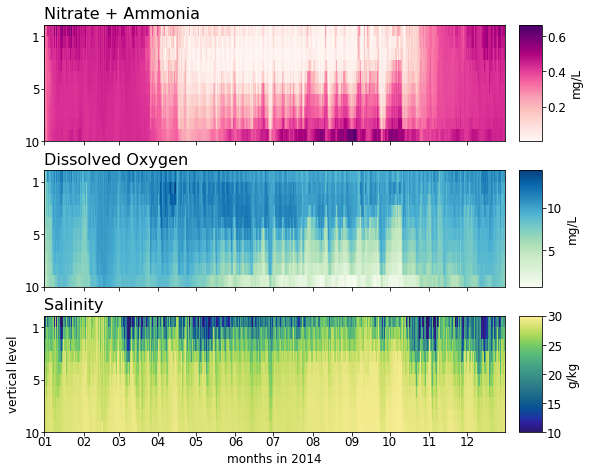

In [9]:
case='base'
fig, axs = plt.subplots(3,1, figsize = (10,5*3/2),
    gridspec_kw={
       'width_ratios': [1],
       'height_ratios': [1,1,1], 
        'wspace': 0.25,
        'hspace': 0.25})
no3mesh=axs[0].pcolormesh(dti,[1,2,3,4,5,6,7,8,9,10],np.flip(NO_2d[case].transpose(),axis=0),cmap='RdPu')
#axs[0].contour(dti,[1,2,3,4,5,6,7,8,9,10],np.flip(NO_2d.transpose(),axis=0),[0.4],colors="white")
doxgmesh=axs[1].pcolormesh(dti,[1,2,3,4,5,6,7,8,9,10],np.flip(DO_2d[case].transpose(),axis=0),cmap='GnBu')
#axs[1].contour(dti,[1,2,3,4,5,6,7,8,9,10],np.flip(DO_2d.transpose(),axis=0),[10],colors="white")
salmesh=axs[2].pcolormesh(dti,[1,2,3,4,5,6,7,8,9,10],np.flip(sal_2d[case].transpose(),axis=0),cmap=cm.cm.haline,vmin=10,vmax=30)
#axs[2].contour(dti, [1,2,3,4,5,6,7,8,9,10],np.flip(sal_2d.transpose(),axis=0), [28], colors='white')

cb0=fig.colorbar(no3mesh, ax=axs[0], pad = 0.025, label='mg/L',aspect=5)
cb1=fig.colorbar(doxgmesh, ax=axs[1], pad = 0.025, label='mg/L',aspect=5)
cb2=fig.colorbar(salmesh, ax=axs[2], pad = 0.025, label='g/kg',aspect=5)

for ya in [0,1,2]:
    axs[ya].set_xlim(np.datetime64('2014-01-01'), np.datetime64('2014-12-31'))
    # set x-ticklabels to the first day of the month
    axs[ya].xaxis.set_major_locator(mpl.dates.MonthLocator())
    axs[ya].xaxis.set_major_formatter(mpl.dates.DateFormatter('%m'))
    axs[ya].set_yticks([0.5,5,9.5])
    axs[ya].set_yticklabels(['10','5','1'])

    
axs[0].set_title('Nitrate + Ammonia',loc='left')
axs[1].set_title('Dissolved Oxygen',loc='left')
axs[2].set_title('Salinity',loc='left')

axs[0].set_xticklabels('')   
axs[1].set_xticklabels('')    
axs[2].set_xlabel('months in 2014')
axs[2].set_ylabel('vertical level')
plt.savefig(pathlib.Path(ssm['paths']['graphics'])/'Hourly_NO3_DOXG_salinity.png',
                bbox_inches='tight',format='png')
plt.show()

In [10]:
delta_salinity=sal_2d['base'][:,0:9] - sal_2d['base'][:,1:10]
delta_salinity.shape

(8784, 9)

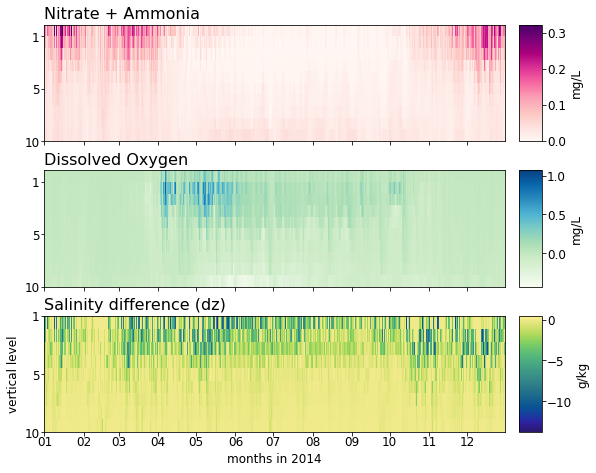

In [11]:
fig, axs = plt.subplots(3,1, figsize = (10,5*3/2),
    gridspec_kw={
       'width_ratios': [1],
       'height_ratios': [1,1,1], 
        'wspace': 0.25,
        'hspace': 0.25})
no3mesh=axs[0].pcolormesh(
    dti,
    [1,2,3,4,5,6,7,8,9,10],
    np.flip(NO_2d['base'].transpose()-NO_2d['ref'].transpose(),
            axis=0),cmap='RdPu')
#axs[0].contour(dti,[1,2,3,4,5,6,7,8,9,10],np.flip(NO_2d.transpose(),axis=0),[0.4],colors="white")
doxgmesh=axs[1].pcolormesh(
    dti,
    [1,2,3,4,5,6,7,8,9,10],
    np.flip(DO_2d['base'].transpose()-DO_2d['ref'].transpose(),
            axis=0),cmap='GnBu')
#axs[1].contour(dti,[1,2,3,4,5,6,7,8,9,10],np.flip(DO_2d.transpose(),axis=0),[10],colors="white")
salmesh=axs[2].pcolormesh(
    dti,
    [1,2,3,4,5,6,7,8,9],
    np.flip(delta_salinity.transpose(),axis=0),cmap=cm.cm.haline)
#axs[2].contour(dti, [1,2,3,4,5,6,7,8,9,10],np.flip(sal_2d.transpose(),axis=0), [28], colors='white')

cb0=fig.colorbar(no3mesh, ax=axs[0], pad = 0.025, label='mg/L',aspect=5)
cb1=fig.colorbar(doxgmesh, ax=axs[1], pad = 0.025, label='mg/L',aspect=5)
cb2=fig.colorbar(salmesh, ax=axs[2], pad = 0.025, label='g/kg',aspect=5)

for ya in [0,1,2]:
    axs[ya].set_xlim(np.datetime64('2014-01-01'), np.datetime64('2014-12-31'))
    # set x-ticklabels to the first day of the month
    axs[ya].xaxis.set_major_locator(mpl.dates.MonthLocator())
    axs[ya].xaxis.set_major_formatter(mpl.dates.DateFormatter('%m'))
    axs[ya].set_yticks([0.5,5,9.5])
    axs[ya].set_yticklabels(['10','5','1'])

    
axs[0].set_title('Nitrate + Ammonia',loc='left')
axs[1].set_title('Dissolved Oxygen',loc='left')
axs[2].set_title('Salinity difference (dz)',loc='left')

axs[0].set_xticklabels('')   
axs[1].set_xticklabels('')    
axs[2].set_xlabel('months in 2014')
axs[2].set_ylabel('vertical level')
plt.savefig(pathlib.Path(ssm['paths']['graphics'])/'Hourly_NO3_DOXG_deltaSalinity_residuals.png',
                bbox_inches='tight',format='png')
plt.show()

# Calculate the difference between bottom and surface salinity as a proxy for buoyancy

In [12]:
buoyancy = sal_2d['base'][:,-1] - sal_2d['base'][:,0]

buoyancy_24h_avg = []
sal_24h_avg=[]
window = 24
i=0
while i < (len(buoyancy)):
    if i < (len(buoyancy)-window):
        b_avg=buoyancy[i:i+window].mean()
        s_avg=sal_2d['base'][i:i+window,0].mean()
    else:
        b_avg=np.NaN
        s_avg=np.NaN
    buoyancy_24h_avg.append(b_avg)
    sal_24h_avg.append(s_avg)
    i+=1

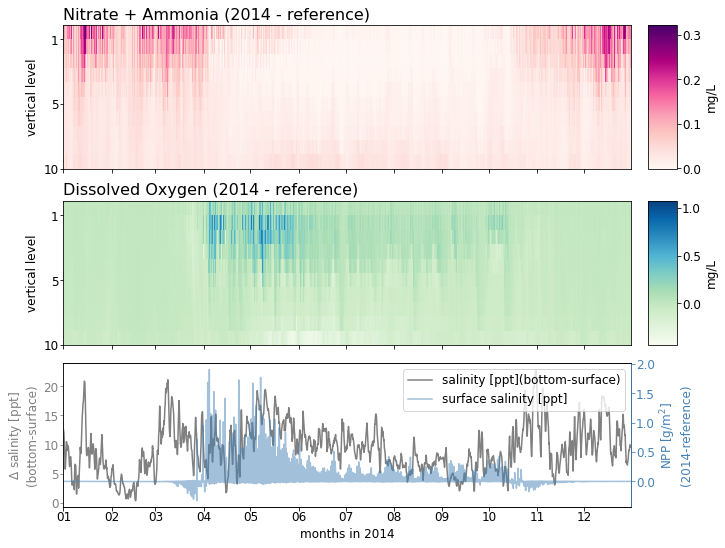

In [13]:
fig, axs = plt.subplots(3,1, 
    figsize = (10,5*3/2),
    constrained_layout=True,
    facecolor='white',
    gridspec_kw={
       'width_ratios': [1],
       'height_ratios': [1,1,1]})
no3mesh=axs[0].pcolormesh(
    dti,
    [1,2,3,4,5,6,7,8,9,10],
    np.flip(NO_2d['base'].transpose()-NO_2d['ref'].transpose(),
            axis=0),cmap='RdPu')
#axs[0].contour(dti,[1,2,3,4,5,6,7,8,9,10],np.flip(NO_2d.transpose(),axis=0),[0.4],colors="white")
doxgmesh=axs[1].pcolormesh(
    dti,
    [1,2,3,4,5,6,7,8,9,10],
    np.flip(DO_2d['base'].transpose()-DO_2d['ref'].transpose(),
            axis=0),cmap='GnBu')
#axs[1].contour(dti,[1,2,3,4,5,6,7,8,9,10],np.flip(DO_2d.transpose(),axis=0),[10],colors="white")
N_line=axs[2].plot(
    dti,
    buoyancy_24h_avg,
    color='grey'
)
# S_line = axs[2].plot(
#     dti,
#     sal_24h_avg,
#     color='seagreen',
#     alpha=0.5
# )
axs3 = axs[2].twinx()
npp_line=axs3.plot(
    dti, NPP_2d['base']-NPP_2d['ref'],
    color='steelblue',
    alpha=0.5,
)

# buoyancy axis color and label 
axs[2].set_ylabel('$\Delta$ salinity [ppt]\n(bottom-surface)', color='grey')
axs[2].tick_params(axis='y', color='grey', labelcolor='grey')
axs[2].spines['left'].set_color('grey')

# NPP axis and label
axs3.set_ylabel('NPP [g/m$^2$]\n(2014-reference)',color='steelblue')
axs3.tick_params(axis='y', color='steelblue', labelcolor='steelblue')
axs3.spines['right'].set_color('steelblue')

# create legend for third subplot
lines = N_line + npp_line
axs[2].legend(lines, ['salinity [ppt](bottom-surface)','surface salinity [ppt]','NPP [g/m$^2$](2014-reference)'])

cb0=fig.colorbar(no3mesh, ax=axs[0], pad=-0.08, label='mg/L',aspect=5)
cb1=fig.colorbar(doxgmesh, ax=axs[1], pad=-0.08, label='mg/L',aspect=5)
#cb2=fig.colorbar(nppmesh, ax=axs[2], pad = 0.025, label='gC/m$^2$',aspect=5)

for ya in [0,1,2]:
    axs[ya].set_xlim(np.datetime64('2014-01-01'), np.datetime64('2014-12-31'))
    # set x-ticklabels to the first day of the month
    axs[ya].xaxis.set_major_locator(mpl.dates.MonthLocator())
    axs[ya].xaxis.set_major_formatter(mpl.dates.DateFormatter('%m'))
    if ya<2:
        axs[ya].set_yticks([0.5,5,9.5])
        axs[ya].set_yticklabels(['10','5','1'])
        axs[ya].set_ylabel('vertical level')

    
axs[0].set_title('Nitrate + Ammonia (2014 - reference)',loc='left')
axs[1].set_title('Dissolved Oxygen (2014 - reference)',loc='left')
#axs[2].set_title('2014 conditions',loc='left')
axs[0].set_xticklabels('')   
axs[1].set_xticklabels('')    
axs[2].set_xlabel('months in 2014')
plt.savefig(pathlib.Path(ssm['paths']['graphics'])/'Hourly_NO3_DOXG_NPP_residuals.png',
                bbox_inches='tight',format='png')
plt.show()

# Take-aways
- Nitrogen levels in the surface are highes prior to april and after november
- Spring freshet is around March 9th
- NPP kicks off toward the latter half of march, presumably due to light availability
- increased NPP increases dissolved O2 in upper levels from april through may. 
- After May, nitrogen in the surface levels is depleted and NPP goes down
- NPP remains low even once Nitrogen levels increase in December, presumably due to light limitation